## Test 12
This test is effectively a unit test of BranchedResourceHeteroSTDP model. While it will test the framework, any error in computing the weights or computing weight updates may not be picked up, but as long as the generated figures are similar (or identical) to the attached ones, there should not be a problem.
The model consists of pairing of synapses through presynaptic spikes (effect decays in time and space) and a potentiation of the pairing by the postsynaptic spike. The weights are constrained in each branch following the equation       

$w_{i}$=$\beta$*$\frac{\alpha_{base, i} + \alpha_{stim, i} *e^{-dt/\tau}}{\omega+\sum_{i=0}^{N}(\alpha_{base, i}+\alpha_{stim, i})}$ 

where $\alpha_{stim, i}$ is the only quantity that varies during the simulation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from ast import literal_eval
import os
import itertools

## Importing data and initial data processing (synapse weights)

In [2]:
base_dir = os.getcwd()+os.sep

data_str1="_HeteroSynapses.dat"
data_str2="_OverallHS.dat"

file1 = [f for f in os.listdir(base_dir) if f.endswith(data_str1)]
file2 = [f for f in os.listdir(base_dir) if f.endswith(data_str2)]

data1 = pd.read_csv(base_dir + file1[0], delimiter='\t', comment='#', header=0)
data2 = pd.read_csv(base_dir + file2[0], delimiter='\t', comment='#', header=0)

data1=data1.drop(columns=data1.columns[-1])
data2=data2.drop(columns=data2.columns[-1])
#data1=data1.iloc[:,2:-1]
#data1=data1.applymap(literal_eval)
#data1["time"]=data2["t"]



#Implement .groupby() factors to discriminate by population, neuron and synapse. The columns can be whatever

In [3]:
times = data1.iloc[::,:1]
#syn_weight_data = data1.iloc[::,1:].applymap(lambda x: x.split(',')[1]).astype('float32')
#alpha_resources_data = data1.iloc[::,1:].applymap(lambda x: x.replace("}", "")).applymap(lambda x: x.split(',')[2]).astype('float32')

In [4]:
pop_column=list()
neuron_column=list()
synapse_column=list()
complete_id=list()
big_time=list()


for i in data1.columns[1:,]:
    complete_id.append(i)
    pop, neuron, synapse=[f for f in i.split("_")[1:]]
    pop_column.append(pop)
    neuron_column.append(neuron)
    synapse_column.append(synapse)
data_points_total=(len(set(pop_column)))*(len(set(neuron_column)))*(len(set(synapse_column)))

pop_column.extend(list(pop_column*(len(data1["t"])-1)))
neuron_column.extend(list(neuron_column*(len(data1["t"])-1)))
synapse_column.extend(list(synapse_column*(len(data1["t"])-1)))
complete_id.extend(list(complete_id*(len(data1["t"])-1)))

temp_df=data1.iloc[::,1:].applymap(lambda x: x.replace("{", "")).applymap(lambda x: x.replace("}", ""))
syn_weight_data = temp_df.applymap(lambda x: x.split(',')[1]).astype('float32').stack()
alpha_resources_data = temp_df.applymap(lambda x: x.split(',')[2]).astype('float32').stack()
branch=temp_df.applymap(lambda x: x.split(',')[0]).astype('float32').stack()
#last_spiketime=data1.iloc[::,1:].applymap(lambda x: x.replace("{", "")).applymap(lambda x: x.replace("}", "")).applymap(lambda x: x.split(',')[3]).astype('float32').stack()

big_time = [itertools.repeat(elem, data_points_total) for elem in times.values.tolist()]
big_time = list(itertools.chain.from_iterable(big_time))
flat_big_time = [float(item) for sublist in big_time for item in sublist]

fdata=pd.DataFrame({'time':flat_big_time,'complete_id':complete_id, 'pop':pop_column, 'neuron':neuron_column, 'synapse':synapse_column, 'weights':syn_weight_data, 'alpha':alpha_resources_data, 'branch':branch})

## Plotting synaptic weights

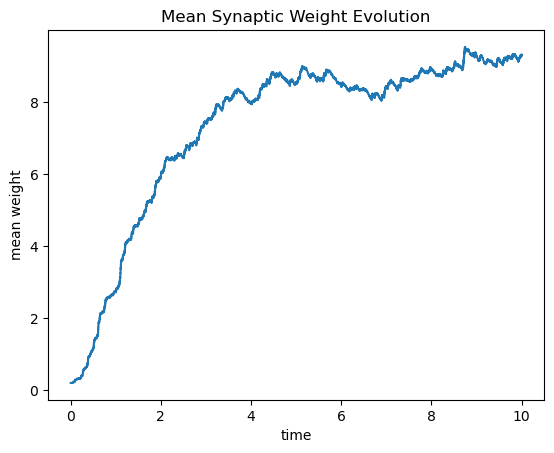

In [5]:
fdata['timefactor']=fdata['time'].astype("string")
mean_wts = fdata.groupby(['time'])['weights'].mean()
plt.plot(times, mean_wts)
plt.title("Mean Synaptic Weight Evolution")
plt.xlabel("time")
plt.ylabel("mean weight")
plt.show()

matrix=fdata.pivot(index='time', columns='complete_id', values='weights')
matrix2=fdata.pivot(index='time', columns='complete_id', values='alpha')

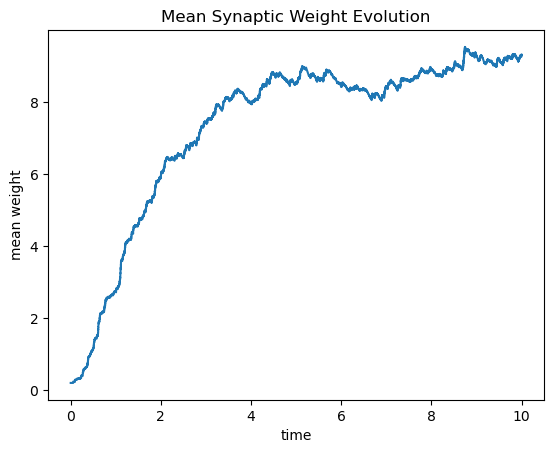

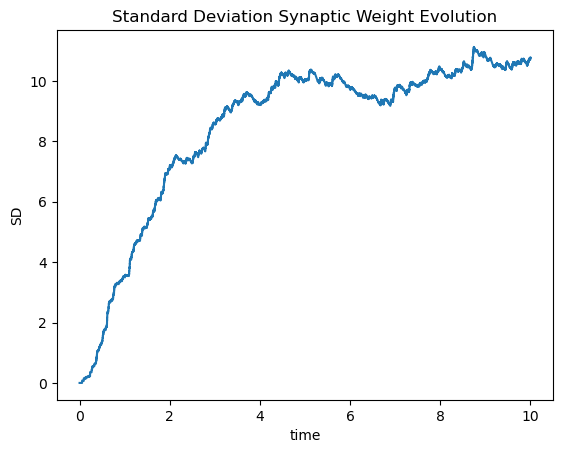

In [6]:
fdata['timefactor']=fdata['time'].astype("string")
std_wts = fdata.groupby(['time'])['weights'].std()
plt.plot(times, std_wts)
plt.title("Standard Deviation Synaptic Weight Evolution")
plt.xlabel("time")
plt.ylabel("SD")
plt.show()

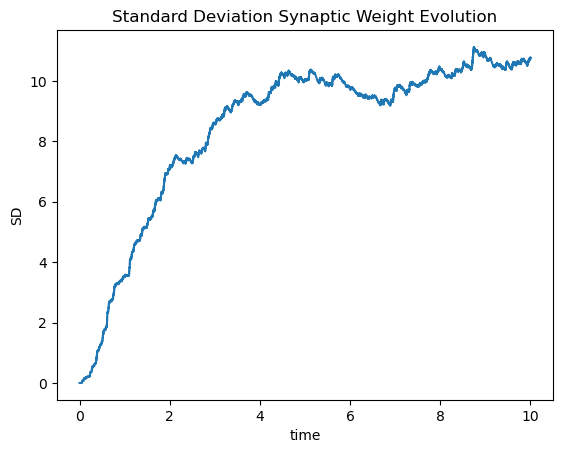

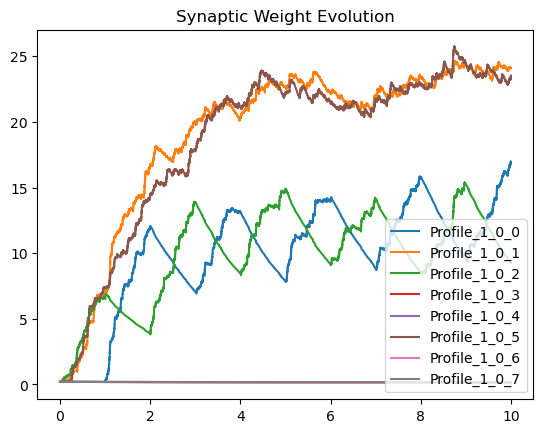

In [7]:
plt.plot(matrix.index, matrix.values, label=matrix.columns[0:])
plt.title("Synaptic Weight Evolution")
plt.legend(loc="lower right")
plt.show()

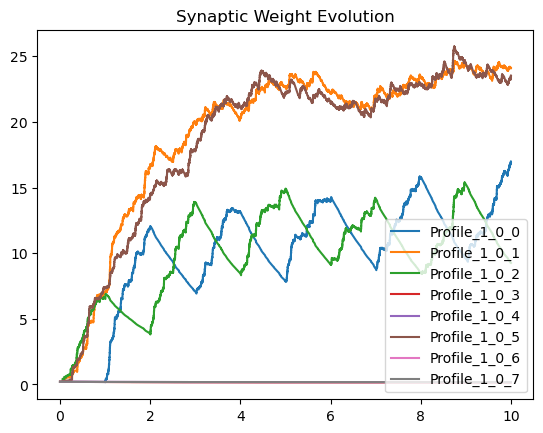

Here we see the synapse weights oscillate as the simulation progresses. From 0 to 3 are all in the same branch, sharing the same resources constraint, while 4 to 7 do not. Because of RandomConnectivity, which synapses oscillate will vary from seed to seed, but the key observation is that the single synapse from branch 2(4-7) is unconstraint by its peers, and the synapse of branch 1 (0-3) that reaches the same weight, is constrained by its peers. To reach the same weight it will require a greater accumulation of alpha. 

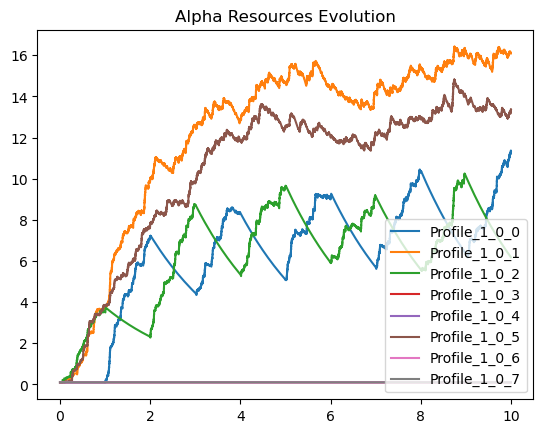

In [8]:
plt.plot(matrix2.index, matrix2.values, label=matrix2.columns[0:])
plt.title("Alpha Resources Evolution")
plt.legend(loc="lower right")
plt.show()

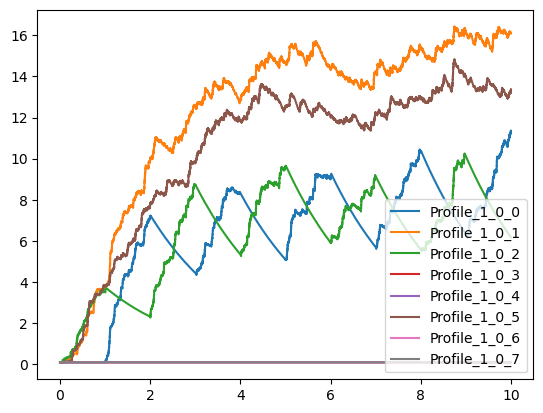

The difference in alphas can be seen in this posterior graph